In [3]:
# Python imports
import os
from dotenv import load_dotenv
import random
from collections import Counter

# Data manipulation
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt

# Statistical analysis
from statsmodels.tsa.stattools import grangercausalitytests

# Machine learning - scikit-learn
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import Lasso, Ridge, ElasticNet
from sklearn.metrics import auc, make_scorer, mean_absolute_error, mean_squared_error, roc_curve, RocCurveDisplay
from sklearn.model_selection import GridSearchCV
from sklearn.inspection import PartialDependenceDisplay

# Machine learning - XGBoost
import xgboost as xgb

# Causal inference
import icpy as icpy
from causallearn.search.ConstraintBased.PC import pc
from causallearn.utils.GraphUtils import GraphUtils
import networkx as nx
from causalimpact import CausalImpact

In [4]:
# Load data
DATA_PATH = "../data/raw/data_ml.csv"
data_ml = pd.read_csv(DATA_PATH)
data_ml['date'] = pd.to_datetime(data_ml['date'])
data_ml['R1M_Usd_C'] = (data_ml['R1M_Usd'] > 0).astype(int) # for classification

In [5]:
# Recreate variables done in notebooks 4 and 5
X = data_ml.iloc[:,3:95] # recall features/predictors, full sample
y = data_ml['R1M_Usd'] # recall label/Dependent variable, full sample

features = X.columns.values.tolist()
features_short = ["Div_Yld", "Eps", "Mkt_Cap_12M_Usd", "Mom_11M_Usd", "Ocf", "Pb", "Vol1Y_Usd"]
separation_date = pd.to_datetime('2013-01-01')
training_sample = data_ml.loc[data_ml['date'] < separation_date]
testing_sample = data_ml.loc[data_ml['date'] > separation_date]


X_short = data_ml[features_short]
X_short_train = training_sample[features_short]
y_short_train = training_sample['R1M_Usd'].values
X_short_test = testing_sample[features_short]
y_short_test = testing_sample['R1M_Usd'].values


y_train = training_sample['R1M_Usd'].values # regression target
X_train = training_sample[features]
X_test = testing_sample[features]
y_test = testing_sample['R1M_Usd'].values

# For XGBoost model
separation_mask = data_ml['date'] < separation_date
data_ml['R1M_Usd_quantile'] = data_ml.groupby('date')['R1M_Usd'].transform(         # creating quantile... 
        lambda x: pd.qcut(x, 100, labels=False, duplicates=('drop'), precision=50)) # ...for selecting extreme values
boolean_quantile=(data_ml.loc[separation_mask]['R1M_Usd_quantile'].        # boolean array for selecting rows
                  values<=0.2) | (data_ml.loc[separation_mask]['R1M_Usd_quantile'].values>=0.8) # selecting extreme values
train_features_xgb=training_sample.loc[boolean_quantile,features_short] # Independent variables
train_label_xgb=training_sample.loc[boolean_quantile,'R1M_Usd'] # Dependent variable
train_matrix_xgb=xgb.DMatrix(train_features_xgb, label=train_label_xgb) # XGB format!

y_penalized = data_ml['R1M_Usd'].values # Dependent variable
X_penalized = data_ml[features].values # Predictors
y_penalized_train = training_sample['R1M_Usd'].values # Dependent variable
X_penalized_train = training_sample[features].values # Predictors

# Chapter 14 Two key concepts: causality and non-stationarity
## 14.1 Causality
### 14.1.1 Granger causality

In [6]:

granger = training_sample.loc[training_sample["stock_id"]==1, # X variable = stock nb 1
                              ["R1M_Usd",                     # Y variable = stock nb 1
                               "Mkt_Cap_6M_Usd"]]             # & Market cap
fit_granger = grangercausalitytests(granger,maxlag=[6])       # Maximmum lag


Granger Causality
number of lags (no zero) 6
ssr based F test:         F=0.7919  , p=0.5776  , df_denom=151, df_num=6
ssr based chi2 test:   chi2=5.1606  , p=0.5234  , df=6
likelihood ratio test: chi2=5.0811  , p=0.5335  , df=6
parameter F test:         F=0.7919  , p=0.5776  , df_denom=151, df_num=6


### 14.1.2 Causal additive models

In [7]:
B=training_sample[['Mkt_Cap_12M_Usd','Vol1Y_Usd']].values          # Node B1 and B2
C=training_sample['R1M_Usd'].values                                # Node C
ExpInd=np.round(np.random.uniform(size=training_sample.shape[0]))  # "Environment"
icpy.invariant_causal_prediction(X=B,y=C,z=ExpInd,alpha=0.1)       # test if A or B are parents of C

ICP(S_hat=array([0, 1]), q_values=array([0., 0.]), p_value=0)

Depth=5, working on node 7: 100%|██████████| 8/8 [00:00<00:00, 638.96it/s] 


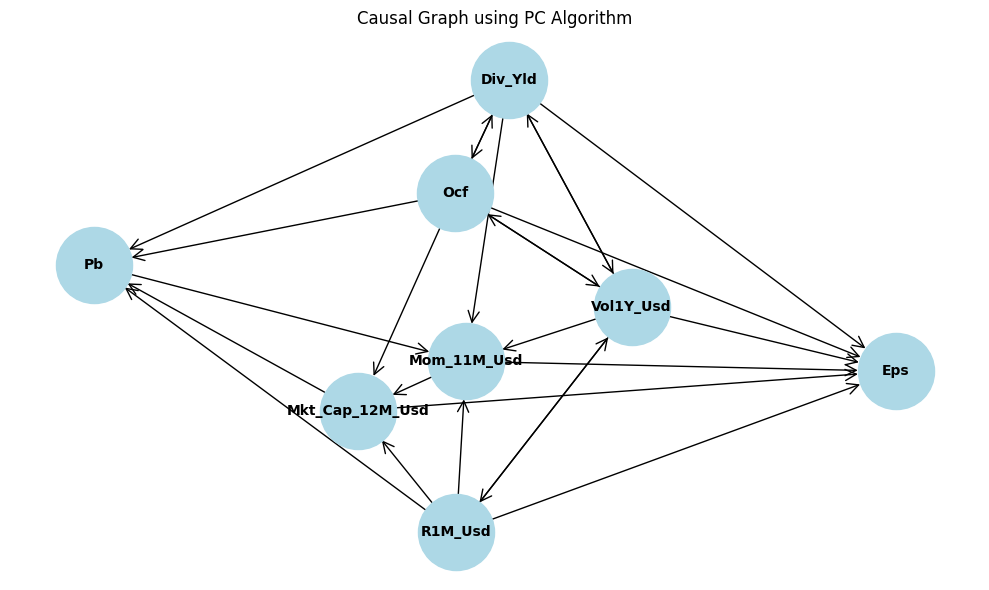


Causal adjacency matrix:
(Rows to Columns: -1 means row->column, 1 means column->row, 0 means no edge)
                 Div_Yld  Eps  Mkt_Cap_12M_Usd  Mom_11M_Usd  Ocf  Pb  \
Div_Yld                0   -1                0           -1   -1  -1   
Eps                    1    0                1            1    1   0   
Mkt_Cap_12M_Usd        0   -1                0            1    1  -1   
Mom_11M_Usd            1   -1               -1            0    0   1   
Ocf                   -1   -1               -1            0    0  -1   
Pb                     1    0                1           -1    1   0   
Vol1Y_Usd             -1   -1                0           -1   -1   0   
R1M_Usd                0   -1               -1           -1    0  -1   

                 Vol1Y_Usd  R1M_Usd  
Div_Yld                 -1        0  
Eps                      1        1  
Mkt_Cap_12M_Usd          0        1  
Mom_11M_Usd              1        1  
Ocf                     -1        0  
Pb                 

In [8]:
# Causal discovery using PC algorithm (pure Python, no R required)
# Select a subset of features for causal analysis
df = training_sample[features_short + ['R1M_Usd']].dropna()
data = df.values

# Run PC algorithm for causal discovery
cg = pc(data, alpha=0.05, indep_test='fisherz')

# Get the graph and nodes
graph_matrix = cg.G.graph  # Get the adjacency matrix
nodes = df.columns.tolist()

# Convert to networkx graph for visualization
G = nx.DiGraph()
G.add_nodes_from(range(len(nodes)))

# Add edges from the adjacency matrix
# In causal-learn: -1 means edge from i to j, 1 means edge from j to i
for i in range(graph_matrix.shape[0]):
    for j in range(graph_matrix.shape[1]):
        if graph_matrix[i, j] == -1:  # i -> j
            G.add_edge(i, j)
        elif graph_matrix[i, j] == 1:  # j -> i
            G.add_edge(j, i)

# Visualize the causal graph
fig = plt.figure(figsize=[10, 6])
pos = nx.spring_layout(G, seed=42)
node_labels = {i: nodes[i] for i in range(len(nodes))}
nx.draw_networkx(G, pos, labels=node_labels, node_color='lightblue', 
                 node_size=3000, font_size=10, font_weight='bold',
                 arrows=True, arrowsize=20, arrowstyle='->')
plt.title('Causal Graph using PC Algorithm')
plt.axis('off')
plt.tight_layout()
plt.show()

# Print the discovered causal relationships
print("\nCausal adjacency matrix:")
print("(Rows to Columns: -1 means row->column, 1 means column->row, 0 means no edge)")
print(pd.DataFrame(graph_matrix, columns=nodes, index=nodes))

### 14.1.3 Structural time series models

d:\Code\ml-for-factor-investing\.venv\Lib\site-packages\causalimpact\main.py:603: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  if not data.applymap(np.isreal).values.all():
d:\Code\ml-for-factor-investing\.venv\Lib\site-packages\causalimpact\main.py:302: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  self.mu_sig = (mu[0], sig[0])
d:\Code\ml-for-factor-investing\.venv\Lib\site-packages\statsmodels\tsa\filters\hp_filter.py:100: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  trend = spsolve(I+lamb*K.T.dot(K), x, use_umfpack=use_umfpack)
d:\Code\ml-for-factor-investing\.venv\Lib\site-packages\statsmodels\base\optimizer.py:21: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword a

Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    0.84               83.71
Prediction (s.d.)         0.83 (0.01)        82.99 (1.27)
95% CI                    [0.81, 0.86]       [80.53, 85.52]

Absolute effect (s.d.)    0.01 (0.01)        0.72 (1.27)
95% CI                    [-0.02, 0.03]      [-1.81, 3.18]

Relative effect (s.d.)    0.86% (1.54%)      0.86% (1.54%)
95% CI                    [-2.19%, 3.83%]    [-2.19%, 3.83%]

Posterior tail-area probability p: 0.3
Posterior prob. of a causal effect: 69.73%

For more details run the command: print(impact.summary('report'))


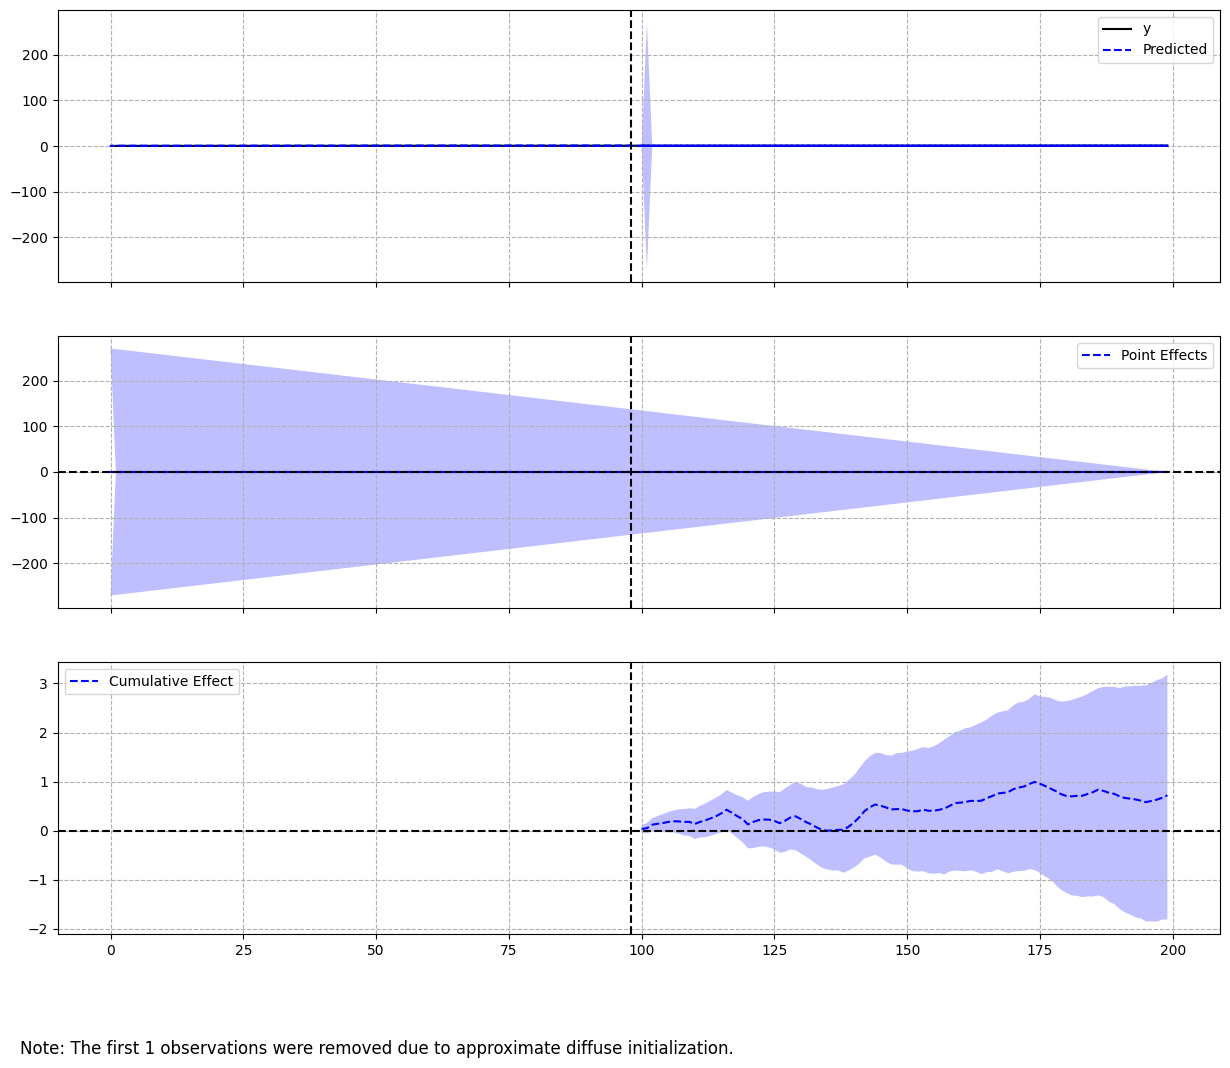

In [17]:
stock1_data = data_ml.loc[data_ml["stock_id"]==1, :]
struct_data = stock1_data[["Advt_3M_Usd"]+features_short].copy()
struct_data.index = pd.RangeIndex(start=0, stop=struct_data.shape[0], step=1)
pre_period = [0, 99]
post_period = [100, 199]

impact = CausalImpact(struct_data, pre_period, post_period)
print(impact.summary())
impact.plot()

## 14.2 Dealing with changing environments